In [97]:
import numpy as np
from typing import Callable
import matplotlib
import matplotlib.pyplot as plt
# Do not pick MacOsx because it will crash the jupyter kernel 
#matplotlib.use('nbAgg')  # Replace 'TkAgg' with your preferred backend

# The goal is to express all polynomials with a neural network that only uses relu activation functions
# many thanks to Nikolaj-K @ https://www.youtube.com/watch?v=PApGm1TKFHQ for the topic
# rewrote it in a different way

# Utils


In [98]:
def plot(x: np.ndarray) -> Callable[[np.ndarray,str,str], None]:
    """
    Curries X into the plot function
    """
    def fn(y: np.ndarray, label: str, color: str) -> None:
        plt.plot(x, y, label=label, color=color)
    return lambda y,label,color : fn(y,label,color)


def plt_setup(xlim:tuple = (0,1), ylim:tuple = (0,1), title:str = "getting $a*(X^2)+b$ from Relus is the goal") -> None:
    plt.grid(True)
    # plt.style.use('dark_background')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.style.use('dark_background')
    return None

color_cycle = matplotlib.colormaps["Spectral"]

X=np.arange(0,1,0.001)
p = plot(X)


# STEP 1 : get X^2 from adding piecewise linear functions (triangle wave functions)

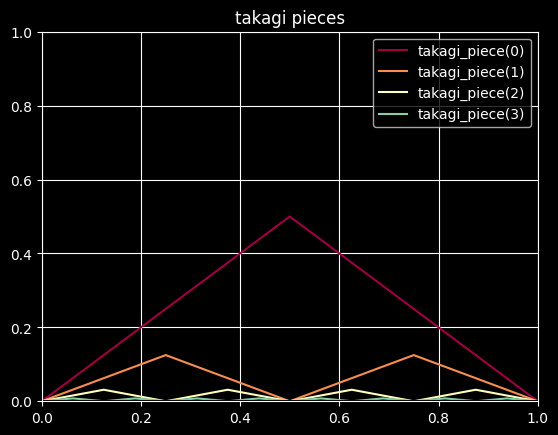

In [103]:
def triangle_wave(x: np.ndarray) -> np.ndarray:
    """ 
    we call this $S_n(x)$ below
    """
    left = x-np.floor(x)
    right = np.ceil(x)-x
    return (left < right)*left + (left >= right)*right


def takagi(N: int) -> np.ndarray:
    # https://en.wikipedia.org/wiki/Blancmange_curve
    return np.stack([takagi_piece(i) for i in range(N)], axis=1).sum(axis=1)


def takagi_piece(i: int) -> np.ndarray:
    w = 0.25  # w=1/4 gives the parabola !
    return (w**i) * triangle_wave((2**i)*X)


# Let's print the takagi pieces once by one and see what they look like
p(takagi_piece(0), "takagi_piece(0)", color=color_cycle(0.0))
p(takagi_piece(1), "takagi_piece(1)", color=color_cycle(0.25))
p(takagi_piece(2), "takagi_piece(2)", color=color_cycle(0.5))
p(takagi_piece(3), "takagi_piece(3)", color=color_cycle(0.75))
plt_setup(title="takagi pieces")
plt.legend(loc="best")
plt.show()

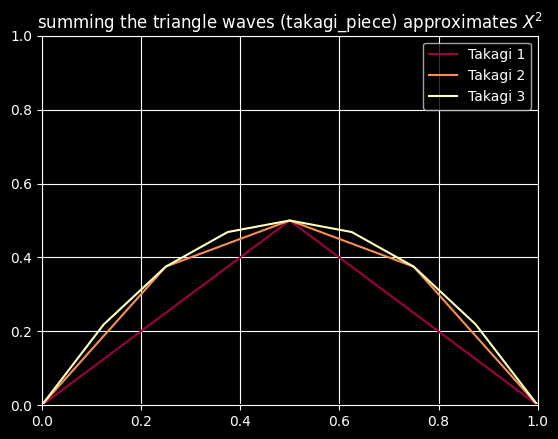

In [112]:
p(takagi(1), "Takagi 1", color=color_cycle(0.0))
p(takagi(2), "Takagi 2", color=color_cycle(0.25))
p(takagi(3), "Takagi 3", color=color_cycle(0.50))
plt_setup(title="summing the triangle waves (takagi_piece) approximates $X^2$")
plt.legend(loc='best')
plt.show()

# Step 2 : get the triangle wave functions from Relus

Now we will try to recreate this but only with linear combinations of Relus and shifted relus (essentially a neural network with 1 input x, Relus as the activation function) 

In [117]:
class TensorFunction:
    def __init__(self, func: Callable[[np.ndarray], np.ndarray]):
        self.func = func

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.func(x)

    def __add__(self, other):
        if isinstance(other, TensorFunction):
            return TensorFunction(lambda x: self(x) + other(x))
        else:
            raise ValueError("Unsupported type for addition")

    def __sub__(self, other):
        if isinstance(other, TensorFunction):
            return TensorFunction(lambda x: self(x) - other(x))
        else:
            raise ValueError("Unsupported type for subtraction")

    def __mul__(self, other):
        if isinstance(other, TensorFunction):
            return TensorFunction(lambda x: self(x) * other(x))
        elif isinstance(other, (int, float)):
            return TensorFunction(lambda x: self(x) * other)
        else:
            raise ValueError("Unsupported type for multiplication")

    def __rmul__(self, other):
        return self.__mul__(other)

    def __neg__(self):
        return TensorFunction(lambda x: -self(x))
    
    def shift(self, shift: float):
        return TensorFunction(lambda x: self(x - shift))


# BASIC FUNCTIONS
# The only TensorFunction we need to get all polynomials is Relu!

Relu = TensorFunction(lambda x : np.maximum(x,0))

# Now we will construct the primitives $\forall n \in \mathbb{N}^* , P_n : [0,1] \to [0,\frac{1}{2}]$

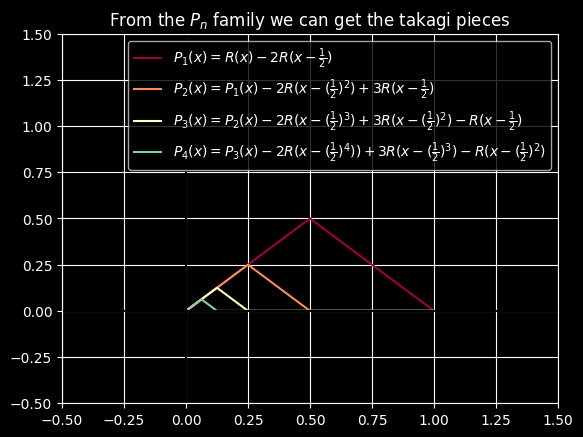

In [133]:
# We cut in half the frist relu and create a triangle
P_1 = Relu-2*Relu.shift(0.5)

p(P_1(X), "$P_1(x) = R(x) - 2R(x-\\frac{1}{2})$", color=color_cycle(0.0))

P_2 = P_1 - 2*Relu.shift(0.25) + 3*Relu.shift(0.5)

p(P_2(X), "$P_2(x)=P_1(x)-2R(x-(\\frac{1}{2})^2)+3R(x-\\frac{1}{2})$", color=color_cycle(0.25))

P_3 = P_2 - 2*Relu.shift(0.125) + 3*Relu.shift(0.25) - Relu.shift(0.5)

p(P_3(X), "$P_3(x)=P_2(x)-2R(x-(\\frac{1}{2})^3)+3R(x-(\\frac{1}{2})^2)-R(x-\\frac{1}{2})$", color=color_cycle(0.5))

P_4 = P_3 - 2*Relu.shift(0.0625) + 3*Relu.shift(0.125) - Relu.shift(0.25)

p(P_4(X), "$P_4(x)=P_3(x)-2R(x-(\\frac{1}{2})^4))+3R(x-(\\frac{1}{2})^3)-R(x-(\\frac{1}{2})^2)$", color=color_cycle(0.75))

plt_setup(xlim=(-0.5,1.5), ylim=(-0.5,1.5), title="From the $P_n$ family we can get the takagi pieces" )
plt.legend(loc='best')
plt.show()

Now we have a family of primitive functions for the triangle wave function at every scale in the interval [0,1]

The general formula to obtain $P_n$ the nth primitive is : 

$P_{n} = P_{n-1} - 2R(x-(1/2)^{n+2}) + 3R(x-(1/2)^{n+1}) - R(x-(1/2)^n)$


We call $T_n : x \in [0,1] \to T_n(x) \in [0,1/2]$ the triangle wave function that has $2^{n-1}$ peaks on $[0,1]$

# Now we will create $T_n$ by adding shifted primitives together

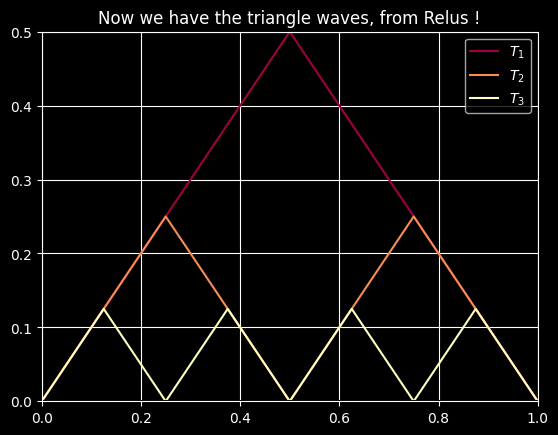

In [137]:

T_1 = P_1

p(T_1(X), "$T_1$", color=color_cycle(0.0))

T_2 = P_2 + P_2.shift(0.5)

p(T_2(X), "$T_2$", color=color_cycle(0.25))

T_3 = P_3 + P_3.shift(0.5) + P_3.shift(0.25) + P_3.shift(0.75)

p(T_3(X), "$T_3$", color=color_cycle(0.5))

plt_setup(xlim=(0,1), ylim=(0,1/2), title="Now we have the triangle waves, from Relus !" )
plt.legend(loc='best')
plt.show()

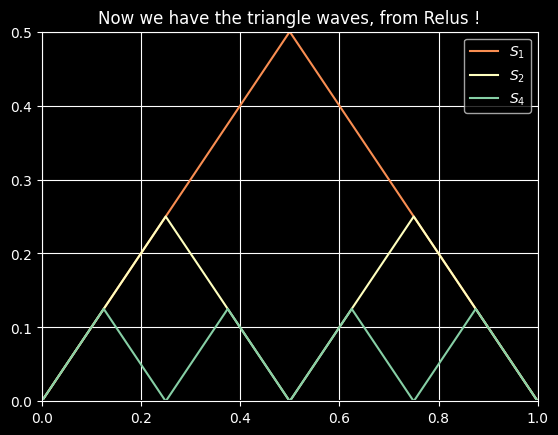

In [87]:
# Now we just need to scale them 
